In [3]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from beakerx import *
plt.style.use('ggplot')
import seaborn as sns
sns.set()
import h5py
import os
from tqdm import tqdm_notebook as tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from scipy.io import loadmat
from matplotlib.mlab import griddata
tableau20 = np.array([(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)])/255.
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
from ipywidgets import interact, FloatSlider,IntSlider, RadioButtons,Dropdown,Tab,Text,SelectMultiple,FloatRangeSlider
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from mpl_toolkits.mplot3d.axes3d import *
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler,Imputer
from sklearn.feature_selection import VarianceThreshold
import numba as nb

Populating the interactive namespace from numpy and matplotlib


/home/xupeng/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
cd /home/xupeng/projects/signal

/home/xupeng/projects/signal


In [5]:
rawdata = loadmat('data/citydata.mat')
RSS = rawdata['RSS']
TOA = rawdata['TOA']
DOA = rawdata['DOA']
TXloc = rawdata['TX']
RXloc = rawdata['RX']

In [6]:
# 寻找原点，做坐标平移
xyzorigin_RX = np.array([np.min(RXloc[:,0]),np.min(RXloc[:,1]),0])
xyzorigin_TX = np.array([np.min(TXloc[:,0]),np.min(TXloc[:,1]),0])
RXloc_shifted = RXloc - xyzorigin_RX
TXloc_shifted = TXloc - xyzorigin_TX

SyntaxError: invalid syntax (<ipython-input-52-f73ee080cfb5>, line 1)

## data imputation

In [8]:
RSS.shape

(1500, 100)

In [6]:
RSS_impute = Imputer(axis=1,strategy='mean').fit_transform(RSS) 
#If axis=1, then impute along rows.
#“mean”,“median”, “most_frequent

## scale

In [7]:
def preprocess(data,method='minmax'):
    if method =='minmax':
        scaler = MinMaxScaler()
        scaler.fit(data)
    elif method =='zscore':
        scaler = StandardScaler()
        scaler.fit(data)
    elif method =='robust':
        scaler = RobustScaler()
        scaler.fit(data)
    return scaler.transform(data),scaler

In [8]:
RSS_scale = preprocess(RSS_impute,method='minmax')[0]

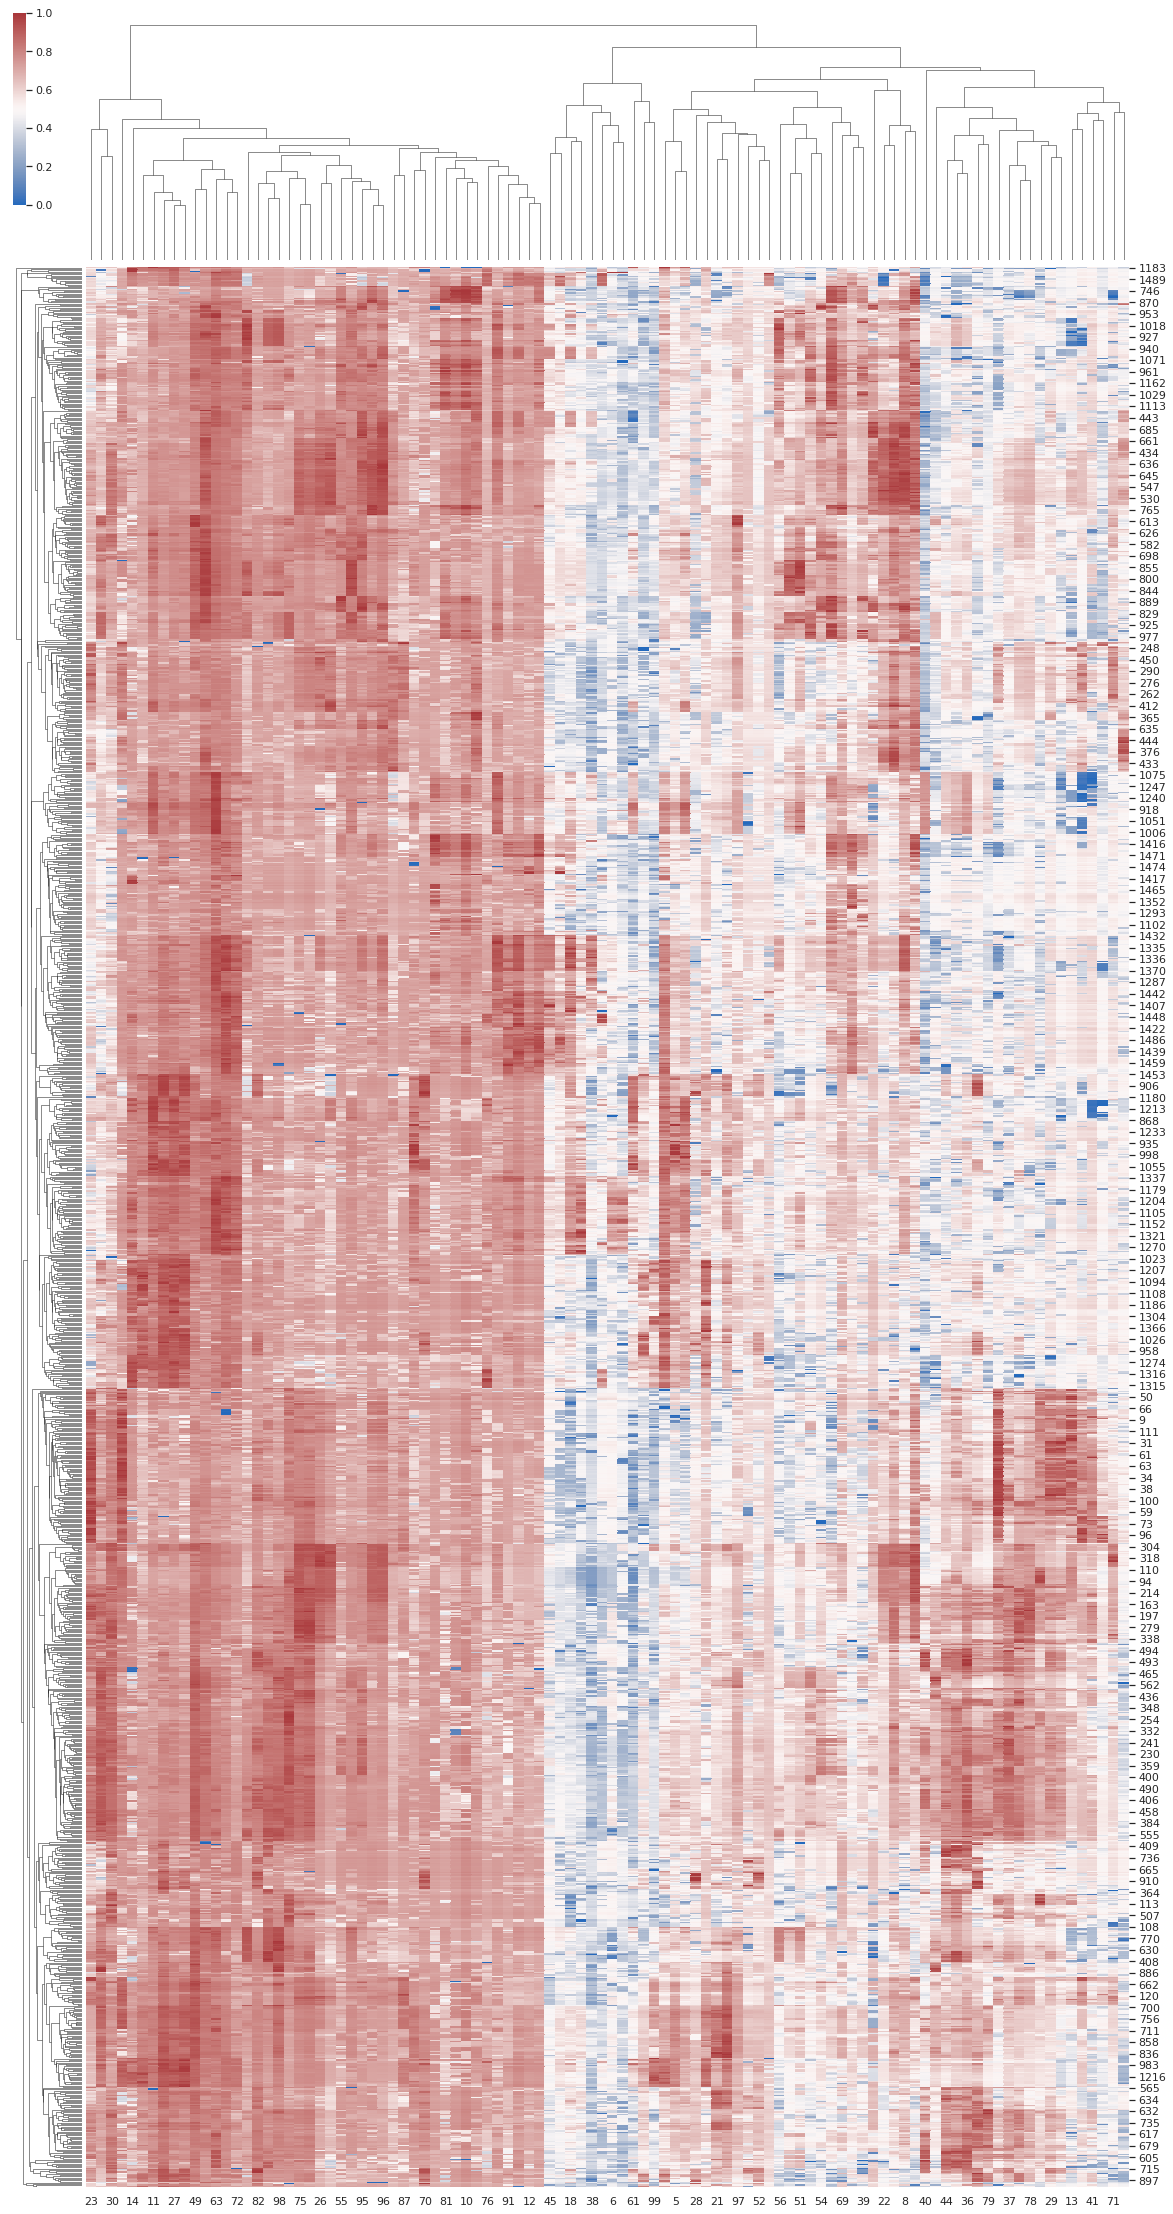

In [9]:
sns.clustermap(RSS_scale,figsize=(20,40),cmap='vlag')

## feature selection

In [10]:
selector = VarianceThreshold()
selector.fit(RSS_scale)

VarianceThreshold(threshold=0.0)

(array([ 7., 22.,  7.,  6.,  4.,  7.,  6.,  7.,  6.,  4.,  7.,  8.,  4.,
         1.,  1.,  1.,  0.,  0.,  1.,  1.]),
 array([0.00327109, 0.00484941, 0.00642773, 0.00800605, 0.00958437,
        0.01116268, 0.012741  , 0.01431932, 0.01589764, 0.01747596,
        0.01905427, 0.02063259, 0.02221091, 0.02378923, 0.02536755,
        0.02694586, 0.02852418, 0.0301025 , 0.03168082, 0.03325914,
        0.03483745]),
 <a list of 20 Patch objects>)

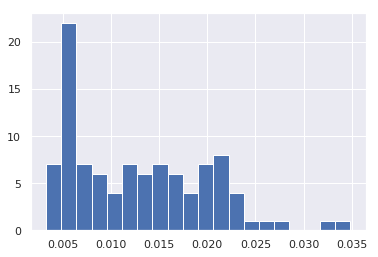

In [11]:
hist(selector.variances_,bins=20)

In [12]:
# 选择前20个
select_ind = np.where(selector.variances_>=np.percentile(selector.variances_,100-20))[0]
select_ind

array([ 2, 13, 18, 19, 23, 32, 33, 36, 37, 40, 41, 46, 56, 60, 61, 68, 74,
       83, 84, 85])

In [13]:
RSS_select[:,select_ind].shape
sns.clustermap(RSS_select[:,select_ind],figsize=(20,40),cmap='vlag')

NameError: name 'RSS_select' is not defined

## MDN
- 2D
- 3D
- 加入TXloc?

In [7]:
sys.path.append('bin')
from utils import prepare_dataset,preprocess_zscore, get_original_parameters, report_metrics, mdn_logp, mdn_loss
from model import MixtureDensityNetwork, IsotropicGaussianMixture
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable # storing data while learning
from torch import optim
from torch.utils import data as utilsdata
import torch.nn.functional as F
from torch.distributions import Categorical
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from scipy.signal import argrelmax
import scipy
import numpy as np

###  3D

In [15]:
X_train, X_test, y_train, y_test = train_test_split(RSS_select[:,select_ind], RXloc_shifted, random_state=42)
scalers = {}
datas = [X_train, X_test, y_train, y_test]
for i in range(4):
    datas[i],scalers[i]  = preprocess(datas[i],'minmax')
X_train_, X_test_, y_train_, y_test_ = datas
batch_size = 10
train_ = utilsdata.TensorDataset(torch.from_numpy(X_train_.astype('float32')),
                                 torch.from_numpy(y_train_.astype('float32')))
test_ = utilsdata.TensorDataset(torch.from_numpy(X_test_.astype('float32')),
                                torch.from_numpy(y_test_.astype('float32')))
train_loader_ = torch.utils.data.DataLoader(
                                            dataset=train_,
                                            batch_size=batch_size,
                                            shuffle=True)
test_loader_ = torch.utils.data.DataLoader(
                                           dataset=test_,
                                           batch_size=batch_size,
                                           shuffle=False)

print('X_train.shape =', X_train.shape, 'X_test.shape =', X_test.shape,
      'y_train.shape =', y_train.shape, 'y_test.shape =', y_test.shape)

NameError: name 'RSS_select' is not defined

In [16]:
model = MixtureDensityNetwork(n_input=X_train.shape[1], n_output=3,  n_components = 3,
                              n_hiddens=[24,22,20],
                              logsigma_min=-3, logsigma_max=1)
optimizer = optim.Adam(model.parameters())

NameError: name 'X_train' is not defined

In [17]:
trainlosses, testlosses = {},{}
for epoch in tqdm(range(2000)):
    train_loss = []
    for i_batch, batch_data in enumerate(train_loader_):
        x, y = batch_data
        model.zero_grad()
        logpi, logsigma, mu = model(x)
        loss = mdn_loss(y, logpi, logsigma, mu)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item()*x.size()[0])
    train_loss = np.sum(train_loss)/len(train_loader_.dataset)

    test_loss = []
    with torch.no_grad():
        for i_batch, batch_data in enumerate(test_loader_):
            x, y = batch_data
            logpi, logsigma, mu = model(x)
            loss = mdn_loss(y, logpi, logsigma, mu)
            test_loss.append(loss.item()*x.size()[0])
        test_loss = np.sum(test_loss)/len(test_loader_.dataset)
    trainlosses[epoch] = train_loss
    testlosses[epoch] = test_loss
    if epoch%10 == 0:
        print('[Epoch {:d}] train loss: {}, test loss: {}'.format(epoch, train_loss, test_loss))
    ###### early stop to avoid unnecessary training######
    if epoch >200:
        if epoch%10 == 0:
            recentlossmin = np.min(np.array([testlosses[i] for i in np.arange(epoch-200,epoch)]))
            otherlossmin = np.min(np.array([testlosses[i] for i in np.arange(0,epoch-200)]))
            print (recentlossmin,otherlossmin)
            if recentlossmin > otherlossmin: # no longer decrease
                print ('exist at epoch:' +str(epoch))
                break


NameError: name 'train_loader_' is not defined

In [104]:
logpi_pred, logsigma_pred, mu_pred = model(torch.Tensor(X_test_))
pi_reversed, sigma_reversed, mu_reversed = get_original_parameters(logpi_pred, logsigma_pred, mu_pred)

def get_prediction(pi,mu,sigma,n_components,n_dim=3):
    model = IsotropicGaussianMixture(n_components, n_dim=n_dim)
    model.set_params(pi,mu,sigma)
    modes = model.find_modes(n_init=10)
    p_modes = model.pdf(modes)
    #print p_modes,modes
    index=np.where(p_modes==np.max(p_modes))
    return p_modes[index[0]], modes[index[0]]

prediction_xy = np.ndarray([pi_reversed.shape[0],3])
probabes = np.ndarray([pi_reversed.shape[0]])
for i in tqdm(range(pi_reversed.shape[0])):
    probabes[i], prediction_xy[i] = get_prediction(pi_reversed[i], mu_reversed[i],sigma_reversed[i],3,3)
prediction_xy_reverse = scalers[3].inverse_transform(prediction_xy)


In [105]:
print ('RMSE: ',np.array([report_metrics(prediction_xy_reverse,y_test)[0]]))
print ('PCC: ',np.array([report_metrics(prediction_xy_reverse,y_test)[1][0]]))

RMSE:  [296.03788244]
PCC:  [0.86218233]


### 2D

In [75]:
X_train, X_test, y_train, y_test = train_test_split(RSS_select[:,select_ind], RXloc_shifted[:,:2], random_state=42)
scalers = {}
datas = [X_train, X_test, y_train, y_test]
for i in range(4):
    datas[i],scalers[i]  = preprocess(datas[i],'minmax')
X_train_, X_test_, y_train_, y_test_ = datas
batch_size = 10
train_ = utilsdata.TensorDataset(torch.from_numpy(X_train_.astype('float32')),
                                 torch.from_numpy(y_train_.astype('float32')))
test_ = utilsdata.TensorDataset(torch.from_numpy(X_test_.astype('float32')),
                                torch.from_numpy(y_test_.astype('float32')))
train_loader_ = torch.utils.data.DataLoader(
                                            dataset=train_,
                                            batch_size=batch_size,
                                            shuffle=True)
test_loader_ = torch.utils.data.DataLoader(
                                           dataset=test_,
                                           batch_size=batch_size,
                                           shuffle=False)

print('X_train.shape =', X_train.shape, 'X_test.shape =', X_test.shape,
      'y_train.shape =', y_train.shape, 'y_test.shape =', y_test.shape)

X_train.shape = (1125, 20) X_test.shape = (375, 20) y_train.shape = (1125, 2) y_test.shape = (375, 2)


In [76]:
model = MixtureDensityNetwork(n_input=X_train.shape[1], n_output=2,  n_components = 5,
                              n_hiddens=[20,18,16],
                              logsigma_min=-3, logsigma_max=1)
optimizer = optim.Adam(model.parameters())

In [77]:
trainlosses, testlosses = {},{}
for epoch in tqdm(range(2000)):
    train_loss = []
    for i_batch, batch_data in enumerate(train_loader_):
        x, y = batch_data
        model.zero_grad()
        logpi, logsigma, mu = model(x)
        loss = mdn_loss(y, logpi, logsigma, mu)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item()*x.size()[0])
    train_loss = np.sum(train_loss)/len(train_loader_.dataset)

    test_loss = []
    with torch.no_grad():
        for i_batch, batch_data in enumerate(test_loader_):
            x, y = batch_data
            logpi, logsigma, mu = model(x)
            loss = mdn_loss(y, logpi, logsigma, mu)
            test_loss.append(loss.item()*x.size()[0])
        test_loss = np.sum(test_loss)/len(test_loader_.dataset)
    trainlosses[epoch] = train_loss
    testlosses[epoch] = test_loss
    if epoch%10 == 0:
        print('[Epoch {:d}] train loss: {}, test loss: {}'.format(epoch, train_loss, test_loss))
    ###### early stop to avoid unnecessary training######
    if epoch >200:
        if epoch%10 == 0:
            recentlossmin = np.min(np.array([testlosses[i] for i in np.arange(epoch-200,epoch)]))
            otherlossmin = np.min(np.array([testlosses[i] for i in np.arange(0,epoch-200)]))
            print (recentlossmin,otherlossmin)
            if recentlossmin > otherlossmin: # no longer decrease
                print ('exist at epoch:' +str(epoch))
                break


[Epoch 0] train loss: 0.765023467640082, test loss: 0.09130799974004428
[Epoch 10] train loss: -0.7136439037322998, test loss: -0.5733419138193131
[Epoch 20] train loss: -0.8156641483306885, test loss: -0.6023123339811961
[Epoch 30] train loss: -0.9724905225965712, test loss: -0.5062265853087108
[Epoch 40] train loss: -1.0438230572806464, test loss: -0.9208617242177327
[Epoch 50] train loss: -1.1214296272065905, test loss: -0.5926363778114319
[Epoch 60] train loss: -1.188785559601254, test loss: -0.8850327181816101
[Epoch 70] train loss: -1.2293006213506064, test loss: -0.8840617847442627
[Epoch 80] train loss: -1.2529130453533597, test loss: -0.9020137715339661
[Epoch 90] train loss: -1.280734191470676, test loss: -0.9290676895777384
[Epoch 100] train loss: -1.3031753129429287, test loss: -1.0077799820899964
[Epoch 110] train loss: -1.3381206968095567, test loss: -1.0448353377978008
[Epoch 120] train loss: -1.3722793425454034, test loss: -0.9960750226179759
[Epoch 130] train loss: -1.

In [81]:
logpi_pred, logsigma_pred, mu_pred = model(torch.Tensor(X_test_))
pi_reversed, sigma_reversed, mu_reversed = get_original_parameters(logpi_pred, logsigma_pred, mu_pred)


prediction_xy = np.ndarray([pi_reversed.shape[0],2])
probabes = np.ndarray([pi_reversed.shape[0]])
for i in tqdm(range(pi_reversed.shape[0])):
    probabes[i], prediction_xy[i] = get_prediction(pi_reversed[i], mu_reversed[i],sigma_reversed[i],5,2)
prediction_xy_reverse = scalers[3].inverse_transform(prediction_xy)


In [82]:
print ('RMSE: ',np.array([report_metrics(prediction_xy_reverse,y_test)[0]]))
print ('PCC: ',np.array([report_metrics(prediction_xy_reverse,y_test)[1][0]]))

RMSE:  [190.71107414]
PCC:  [0.87721413]


In [7]:
distance=np.zeros((1500,1500))
for i in tqdm(range(1500)):
    for j in range(1500):
        distance[i,j]=np.linalg.norm(RXloc_shifted[i]-RXloc_shifted[j])

In [8]:
c=np.append(RSS,TOA,axis=1)
combine_data=np.append(c,DOA,axis=1)


# 总结下面所做的工作.  
根据实际，在两个点的实际距离较近的时候，特征之间也应该相近<br>
relation函数统计两个点的给定特征的相似度，相似度越高，值越接近1。<br>
corelation函数统计对于给定的特征，这些特征是否足够优秀。理论上讲，优秀的特征应该在点的距离近的时候比较类似。所以点的距离越小，relation结果越大。因此，corelation越接近-1，说明特征越好。<br>
对于10个特征，20个特征，30个特征各测试一番。<br>
数据说明，各测试十万个，最终相关值储存在 rela_10 rela_20 rela_30中。<br>
标签储存在labe_10, labe_20, labe_30中<br>
其中用nr_10 nr_20 nr_30来表示计算过程中，有多大比率的nan值。

In [30]:
def relate(index_1, index_2, features):
    xdata=combine_data[index_1]
    xdata=xdata[features]
    ydata=combine_data[index_2]
    ydata=ydata[features]
    an=~np.isnan(xdata)&~np.isnan(ydata)
    xdata=xdata[an]
    nr=1-len(xdata)/len(ydata)
    if len(xdata) == 0:
        return np.nan,1
    ydata=ydata[an]
    an=an[an]
    r=scipy.stats.pearsonr(xdata,ydata)[0]
    return r,nr

In [18]:
def pcc(X, Y):
    X -= X.mean(0)
    Y -= Y.mean(0)
    X /= X.std(0)
    Y /= Y.std(0)
    return np.mean(X*Y)

In [16]:
def corelate(features):
    batchsize=100;
    r=np.zeros(testnum)
    nr=np.zeros(testnum)
    xn=np.random.randint(1,1500,size=(testnum,batchsize))
    yn=np.random.randint(1,1500,size=(testnum,batchsize))
    r=np.zeros((testnum,batchsize))
    u=np.zeros((testnum,batchsize))
    d=np.zeros((testnum,batchsize))
    re=np.zeros(testnum)
    nr=np.zeros(testnum)
    for j in range(testnum):
        nan_num=0;
        for i in range(batchsize):
            d[j][i]=distance[xn[j][i],yn[j][i]]
            r[j][i],u[j][i]=relate(xn[j][i],yn[j][i],features)
            while np.isnan(r[j][i]):
                xn[j][i]=np.random.randint(1,1500)
                yn[j][i]=np.random.randint(1,1500)
                d[j][i]=distance[xn[j][i],yn[j][i]]
                r[j][i],u[j][i]=relate(xn[j][i],yn[j][i],features)
                nan_num=nan_num+1
        re[j]=scipy.stats.pearsonr(d[j],r[j])[0]
        nr[j]=(np.sum(u[j])+nan_num)/(nan_num+batchsize)
    return -np.mean(re), np.mean(nr), xn.flatten(), yn.flatten(), r.flatten(), u.flatten()

In [ ]:
test_counts=1000
point_counts=1000
feature_counts=10

In [33]:
batchsize=100;
testnum=int(point_counts/batchsize)
x_total=np.zeros((test_counts,testnum*batchsize))
y_total=np.zeros((test_counts,testnum*batchsize))
r_total=np.zeros((test_counts,testnum*batchsize))
u_total=np.zeros((test_counts,testnum*batchsize))
relation=np.zeros(test_counts)

label=np.random.randint(1,500,size=(test_counts,feature_counts))

nan_rate=np.zeros(test_counts)

In [26]:
for i in tqdm(range(test_counts)):
    relation[i],nan_rate[i],x_total[i],y_total[i],r_total[i],u_total[i]=corelate(label[i])


In [34]:

index=np.argsort(-relation)
relation=relation[index]
label=label[index]
nan_rate=nan_rate[index]
x_total=x_total[index]
y_total=y_total[index]
u_total=u_total[index]
r_total=r_total[index]

In [28]:
dir_name=(str(feature_counts)+'feature_counts'+str(test_counts)+'test_counts'+str(point_counts)+'point_counts')
path_model = os.path.join('/home/xupeng/projects/signal/citydata/', dir_name)
if not os.path.exists(path_model):
    os.makedirs(path_model)

In [50]:
np.savetxt(path_model+'/pcc.txt',relation)
np.savetxt(path_model+'/label.txt',label,fmt='%d')
np.savetxt(path_model+'/nan_rate.txt',nan_rate,fmt='%4.3f')
np.savetxt(path_model+'/first_index.txt',x_total,fmt='%d')
np.savetxt(path_model+'/second_index.txt',y_total,fmt='%d')
np.savetxt(path_model+'/nanrate_specific.txt',u_total,fmt='%3.2f')
np.savetxt(path_model+'/relation_specific.txt',r_total)